In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import gc

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error

import lightgbm as lgb

import joblib

# 맥에서 글씨 깨짐 방지
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')

* ver7 : 피쳐 줄이고 로그 변환(제출 횟수 때문에 패스)
* ver6 : 피쳐 줄이고 스케일링 없이(lgbm 트리기반이어서 그냥 넣어봤습니다.)
* ver5 : 피쳐 줄이고 outlier iqr
* ver4 : 피쳐 줄이고 hold out
* ver3 : 피쳐 줄이고 stafied k-fold

----

* 줄인 피쳐
Index(['전용면적', '층', '건축년도', '좌표X', '좌표Y', 'target', 'is_test', '가장 가까운 거리',
       '가장 가까운 버스 정류장 거리', '건물나이'],

* 데이터 셋:
홍석님이 슬랙에 올리신 것

# Data Load

In [ ]:
df = pd.read_csv('/root/home_predict/dataset/22_subway_line.csv')

/tmp/ipykernel_620129/636612162.py:1: DtypeWarning: Columns (16,17,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/root/home_predict/dataset/22_subway_line.csv')


## 결측치 제거

In [ ]:
pd.set_option('display.max_rows', None)
df.isnull().sum()

시군구                           0
번지                          227
본번                           75
부번                           75
아파트명                          0
전용면적                          0
계약년월                          0
계약일                           0
층                             0
건축년도                          0
도로명                           0
해제사유발생일                 1121899
등기신청일자                        0
거래유형                          0
중개사소재지                        0
k-단지분류(아파트,주상복합등등)       877273
k-전화번호                   876850
k-팩스번호                   879348
단지소개기존clob              1058958
k-세대타입(분양형태)             876125
k-관리방식                   876125
k-복도유형                   876454
k-난방방식                   876125
k-전체동수                   877207
k-전체세대수                  876125
k-건설사(시공사)                    0
k-시행사                    877834
k-사용검사일-사용승인일            876259
k-연면적                    876125
k-주거전용면적                 876170
k-관리비부과면적                876125
k-전용면적별세

In [ ]:
# Null값이 100만개 이상인 칼럼은 삭제해보도록 하겠습니다.
print('결측치가 100만개 이하인 변수들 :', list(df.columns[df.isnull().sum() <= 1000000])) # 남겨질 변수들은 아래와 같습니다.
print('결측치가 100만개 이상인 변수들 : ', list(df.columns[df.isnull().sum() >= 1000000]))

결측치가 100만개 이하인 변수들 : ['시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도', '도로명', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60이하)', 'k-전용면적별세대현황(60~85이하)', 'k-85~135이하', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일', 'target', 'is_test', '시군구 번지', '좌표X,좌표Y', '가장 가까운 거리', 'index', '역사_ID', '역사명', '호선', '위도', '경도', '인근 지하철 역 개수', '가장 가까운 버스 정류장 거리', '가장 가까운 버스 정류장 index', '가장 가까운 버스 정류장 노드 ID', '가장 가까운 버스 정류소번호', '가장 가까운 버스 정류소명', '가장 가까운 버스 정류소 타입', '가장 가까운 버스 정류장 X좌표', '가장 가까운 버스 정류장 Y좌표', '인근 버스 정류장 개수', '계약년', '계약월', 'GDP', '한국은행 기준금리', '기대 인플레이션', '지가지수', '아파트 인허가', '미분양', '거래량', '건설사 랭킹', '구', '동', '구별 지가지수', '공시지가 평균', '매수우위지수', '건물나이', '30년이상50년이하', '구매력지수', '거래활발지수', '매매가격 지수 증감률', '매매

In [ ]:
df.drop(['해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호',
         'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)', 'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수',
         'k-사용검사일-사용승인일', 'k-관리비부과면적', 'k-전용면적별세대현황(60이하)', 'k-전용면적별세대현황(60~85이하)',
         'k-85~135이하', 'k-135초과', 'k-홈페이지', 'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태',
         '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '단지신청일'], axis=1, inplace=True)

In [ ]:
df.drop(['시군구', '번지', '본번', '부번', '아파트명', '도로명', 'k-관리방식', 'k-건설사(시공사)', 'k-시행사', 'k-연면적', 'k-주거전용면적',
         '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '시군구 번지', '좌표X,좌표Y', 'index', '역사_ID', '역사명', '위도', '경도',
         '가장 가까운 버스 정류장 index', '가장 가까운 버스 정류장 노드 ID', '가장 가까운 버스 정류소번호', '가장 가까운 버스 정류소명',
         '가장 가까운 버스 정류소 타입', '가장 가까운 버스 정류장 X좌표', '가장 가까운 버스 정류장 Y좌표', '동', 
         ], axis=1, inplace=True)

In [ ]:
df.drop(['호선', '인근 지하철 역 개수', '인근 버스 정류장 개수', '한국은행 기준금리', '기대 인플레이션', '지가지수', '아파트 인허가', '미분양',
       '거래량', '건설사 랭킹', '구', '구별 지가지수', '공시지가 평균', '매수우위지수','30년이상50년이하', '구매력지수', '거래활발지수', '매매가격 지수 증감률', '매매 대비 전세가격 비율',
       '아파트 카테고리', '지하철 카테고리','GDP'],axis = 1, inplace=True)

In [ ]:
# 계약년월, 계약일, 건축년도, 계약년 변수 제거

df.drop(['계약년월', '계약일','계약년'], axis=1, inplace=True)

In [ ]:

df.drop(['계약월_sin'], axis=1, inplace=True)

In [ ]:
df.columns

Index(['전용면적', '층', '건축년도', '좌표X', '좌표Y', 'target', 'is_test', '가장 가까운 거리',
       '가장 가까운 버스 정류장 거리', '건물나이'],
      dtype='object')

In [ ]:
def scailing(col, scaler_type):
    if scaler_type == 'min_max': scaler = MinMaxScaler()
    else : scaler = StandardScaler()

    return scaler.fit_transform(df[[col]])

cols = ['전용면적', '층', '건축년도', '좌표X', '좌표Y', '가장 가까운 거리',
       '가장 가까운 버스 정류장 거리', '건물나이']

for col in cols:
    print(col)
    scaler_type = 'min_max'
    # if col == ['계약월_sin']: scaler_type = 'standard'

    df[[col]] = scailing(col, scaler_type)

## train, test 분할

In [ ]:
# 추가한 feature들 중 일부 제거
df_dropped = df.drop([], axis=1)

In [ ]:
df_dropped.columns

Index(['전용면적', '층', '건축년도', '좌표X', '좌표Y', 'target', 'is_test', '가장 가까운 거리',
       '가장 가까운 버스 정류장 거리', '건물나이'],
      dtype='object')

In [ ]:
train_df = df_dropped[df_dropped['is_test'] == 0]
test_df = df_dropped[df_dropped['is_test'] == 1]

In [ ]:
train_df.drop(['is_test'], axis = 1, inplace=True)
test_df.drop(['is_test'], axis = 1, inplace=True)

/tmp/ipykernel_620129/3351882249.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop(['is_test'], axis = 1, inplace=True)
/tmp/ipykernel_620129/3351882249.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop(['is_test'], axis = 1, inplace=True)


In [ ]:
print(train_df.shape)
print(test_df.shape)

(1118822, 9)
(9272, 9)


In [ ]:
train_X, valid_X, train_y, valid_y = train_test_split(train_X, train_y, train_size=0.95, test_size=0.05, random_state=74)

print(train_X.shape, train_y.shape)
print(valid_X.shape, valid_y.shape)

(1062880, 8) (1062880,)
(55942, 8) (55942,)


In [ ]:
params = {
    'n_estimators': 100000,
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'metric_freq': 20,
    'device': 'gpu',
    'verbosity': 0
}

model = lgb.LGBMRegressor(n_estimators=100000,
                          metric='rmse', data_sample_strategy='goss'
                          )

model.fit(
    train_X, train_y,
    eval_set = [(train_X, train_y), (valid_X, valid_y)],
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(stopping_rounds=60),
               lgb.log_evaluation(period=10, show_stdv=True)]
)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003550 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1465
[LightGBM] [Info] Number of data points in the train set: 1062880, number of used features: 8
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 57982.908459
Training until validation scores don't improve for 60 rounds
[10]	training's rmse: 30239.2	valid_1's rmse: 30761.5
[20]	training's rmse: 23903.6	valid_1's rmse: 24222.7
[30]	training's rmse: 20530.1	valid_1's rmse: 20718.8
[40]	training's rmse: 18328	valid_1's rmse: 18455.3
[50]	training's rmse: 16747.8	valid_1's rmse: 16856.4
[60]	training's rmse: 15727.1	valid_1's rmse: 15812.2
[70]	training's r

LGBMRegressor(data_sample_strategy='goss', metric='rmse', n_estimators=100000)

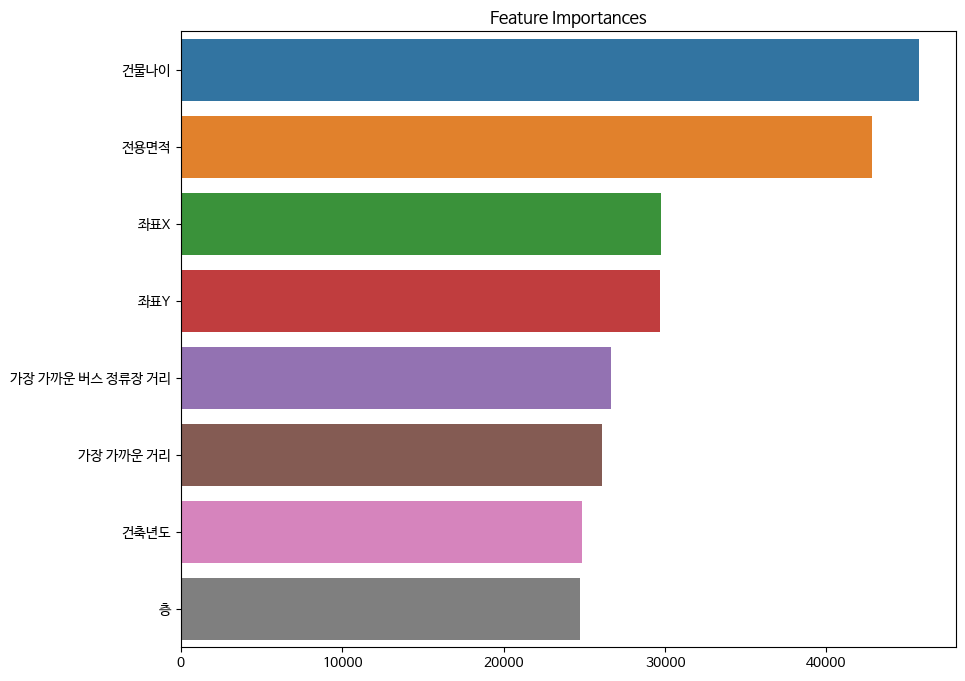

In [ ]:
importances = pd.Series(model.feature_importances_, index=list(train_X.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [ ]:
preds = model.predict(test_df)

In [ ]:
preds = np.round(preds).astype(int)

In [ ]:
preds_df = pd.DataFrame(preds, columns=['target'])

In [ ]:
preds_df.to_csv('../pred.csv', index=False)